In [2]:
"""
C10でFine-tuningしたViTモデルのフォワードパスを実行する
"""

import os, sys, math
sys.path.append("../src")
import numpy as np
import torch
from datasets import load_dataset, load_metric
from transformers import DefaultDataCollator, ViTForImageClassification, TrainingArguments, Trainer
from utils.helper import get_device
from utils.vit_util import processor, transforms, compute_metrics

2024-04-19 15:26:34.288151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 15:26:35.392791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-19 15:26:35.392928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-19 15:26:35.392939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [62]:
# dsのsaveとload
cifar10.save_to_disk("cifar10")

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [66]:
# dsのsaveとload
from datasets import load_from_disk
cifar10 = load_from_disk("cifar10")
cifar10

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [3]:
# デバイス (cuda, or cpu) の取得
device = get_device()
# datasetをロード (初回の読み込みだけやや時間かかる)
cifar10 = load_dataset("cifar10")
# 読み込まれた時にリアルタイムで前処理を適用するようにする
cifar10_preprocessed = cifar10.with_transform(transforms)
# バッチごとの処理のためのdata_collator
data_collator = DefaultDataCollator()
# ラベルを示す文字列のlist
labels = cifar10_preprocessed["train"].features["label"].names
# pretrained modelのロード
pretrained_dir = "/src/src/out_vit_c10"
model = ViTForImageClassification.from_pretrained(pretrained_dir).to(device)
model.eval()
# 学習時の設定をロード
training_args = torch.load(os.path.join(pretrained_dir, "training_args.bin"))
# Trainerオブジェクトの作成
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=cifar10_preprocessed["train"],
    eval_dataset=cifar10_preprocessed["test"],
    tokenizer=processor,
)

Device: cuda


Found cached dataset parquet (/root/.cache/huggingface/datasets/parquet/plain_text-d4c080360fb556b0/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=False,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_tok

In [3]:
# nameが vit.encoder.layer.{i}.intermediate.dense.weight のパターンにマッチするレイヤだけ表示 (iは数字)
for name, param in model.named_parameters():
    if "vit.encoder.layer" in name and "intermediate.dense.weight" in name:
        print(name, param.size())

vit.encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.1.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.2.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.3.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.4.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.5.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.6.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.7.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.8.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.9.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.10.intermediate.dense.weight torch.Size([3072, 768])
vit.encoder.layer.11.intermediate.dense.weight torch.Size([3072, 768])


In [6]:
dum_input = cifar10_preprocessed["train"][:5]["pixel_values"].to(device)
dum_input.shape

torch.Size([5, 3, 224, 224])

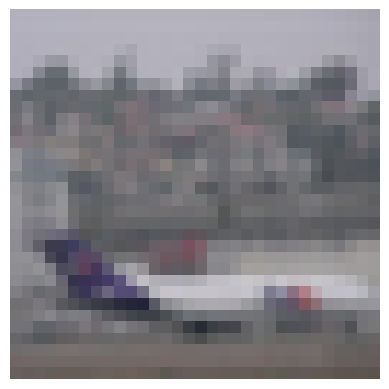

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


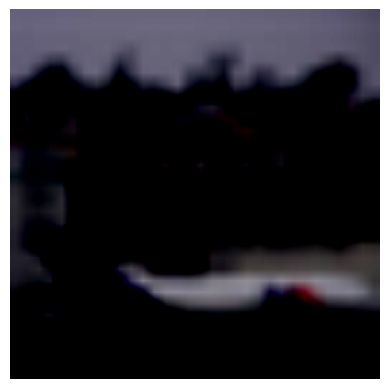

In [44]:
import torch
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

transform = transforms.ToTensor()
tensor = transform(cifar10["train"][0]["img"])

# テンソルを画像として表示します
plt.imshow(tensor.permute(1, 2, 0))  # テンソルの次元を(64, 64, 3)に変換して表示します
plt.axis('off')  # 軸を非表示にします
plt.show()

# テンソルを画像として表示します
plt.imshow(cifar10_preprocessed["train"][0]["pixel_values"].permute(1, 2, 0))  # テンソルの次元を(64, 64, 3)に変換して表示します
plt.axis('off')  # 軸を非表示にします
plt.show()

In [58]:
for entry_dic in cifar10_preprocessed["train"].iter(batch_size=32):
    x, y = entry_dic["pixel_values"], entry_dic["labels"]
    print(x.shape, len(y))
    print(y)
    break

torch.Size([32, 3, 224, 224]) 32
[0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1, 4, 2, 3, 2, 1, 2, 8, 9, 5, 0, 7, 6]


In [9]:
mf = model.forward(dum_input, output_hidden_states=True, output_attentions=True, output_intermediate_states=True)
print(mf.keys())
# 後ろの3つのキーのタプルの長さを取得
print([len(mf[k]) for k in list(mf.keys())[-3:]])

odict_keys(['logits', 'hidden_states', 'attentions', 'intermediate_states'])
[13, 12, 12]


In [5]:
mf.logits.shape

torch.Size([5, 10])

In [6]:
print(len(mf.hidden_states))
for i, hs in enumerate(mf.hidden_states):
    print(f"mf.hidden_states[{i}].shape = {hs.shape}")
    print(f"mf.hidden_states[{i}][:, 0, :].shape = {hs[:, 0, :].shape}")

13
mf.hidden_states[0].shape = torch.Size([5, 197, 768])
mf.hidden_states[0][:, 0, :].shape = torch.Size([5, 768])
mf.hidden_states[1].shape = torch.Size([5, 197, 768])
mf.hidden_states[1][:, 0, :].shape = torch.Size([5, 768])
mf.hidden_states[2].shape = torch.Size([5, 197, 768])
mf.hidden_states[2][:, 0, :].shape = torch.Size([5, 768])
mf.hidden_states[3].shape = torch.Size([5, 197, 768])
mf.hidden_states[3][:, 0, :].shape = torch.Size([5, 768])
mf.hidden_states[4].shape = torch.Size([5, 197, 768])
mf.hidden_states[4][:, 0, :].shape = torch.Size([5, 768])
mf.hidden_states[5].shape = torch.Size([5, 197, 768])
mf.hidden_states[5][:, 0, :].shape = torch.Size([5, 768])
mf.hidden_states[6].shape = torch.Size([5, 197, 768])
mf.hidden_states[6][:, 0, :].shape = torch.Size([5, 768])
mf.hidden_states[7].shape = torch.Size([5, 197, 768])
mf.hidden_states[7][:, 0, :].shape = torch.Size([5, 768])
mf.hidden_states[8].shape = torch.Size([5, 197, 768])
mf.hidden_states[8][:, 0, :].shape = torch.Size

In [10]:
print(len(mf.attentions))
for i, attn in enumerate(mf.attentions):
    print(f"mf.attentions[{i}].shape = {attn.shape}")

12
mf.attentions[0].shape = torch.Size([5, 12, 197, 197])
mf.attentions[1].shape = torch.Size([5, 12, 197, 197])
mf.attentions[2].shape = torch.Size([5, 12, 197, 197])
mf.attentions[3].shape = torch.Size([5, 12, 197, 197])
mf.attentions[4].shape = torch.Size([5, 12, 197, 197])
mf.attentions[5].shape = torch.Size([5, 12, 197, 197])
mf.attentions[6].shape = torch.Size([5, 12, 197, 197])
mf.attentions[7].shape = torch.Size([5, 12, 197, 197])
mf.attentions[8].shape = torch.Size([5, 12, 197, 197])
mf.attentions[9].shape = torch.Size([5, 12, 197, 197])
mf.attentions[10].shape = torch.Size([5, 12, 197, 197])
mf.attentions[11].shape = torch.Size([5, 12, 197, 197])


In [11]:
print(len(mf.intermediate_states))
for i, med in enumerate(mf.intermediate_states):
    print(f"mf.intermediate_states[{i}].shape = {med.shape}")

12
mf.intermediate_states[0].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[1].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[2].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[3].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[4].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[5].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[6].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[7].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[8].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[9].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[10].shape = torch.Size([5, 197, 3072])
mf.intermediate_states[11].shape = torch.Size([5, 197, 3072])
